<a href="https://colab.research.google.com/github/nambiar/MachineLearning/blob/master/Session6/Assignment_6b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.layers import SeparableConv2D
from keras.layers import Input
from keras.layers.merge import concatenate
# Shared Feature Extraction Layer
from keras.utils import plot_model

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

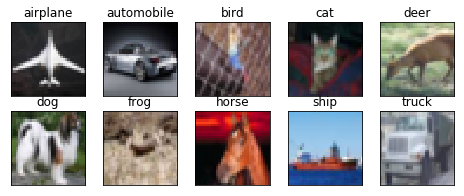

In [54]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [69]:
# Define the model
# define input
#Unlike the Sequential model, you must create and define a standalone Input layer that specifies the shape of input data.
InputData = Input(shape=(32, 32, 3))
Convlayer = Convolution2D(128, 3, 3, activation='relu',border_mode='same', input_shape=(32, 32, 3),kernel_regularizer=regularizers.l2(0.00001))(InputData) #32 #3
Convlayer_batch = BatchNormalization()(Convlayer)
Convlayer_dropout = Dropout(0.1)(Convlayer_batch)

#Output 32*32*128
#Applying Spatially Separable Convolution
#input(32 *32 * 128) * (3*1*128) = 30 * 32 *128
# Output * (1*3*128) = 30 *30 *128

spatialConvLayer_1 = Convolution2D(128, 3, 1,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(Convlayer_dropout)
spatialConvLayer_2 =Convolution2D(128, 1, 3,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(spatialConvLayer_1)
spatialConvLayer_batch = BatchNormalization()(spatialConvLayer_2)
spatialConvLayer_dropout = Dropout(0.1)(spatialConvLayer_batch)


#input 30*30*128
#applying depthwise convolution
# Depthwise Separable Convolution
#30*30*128 = 28*28*64
depthwiseConvLayer = SeparableConv2D(64, (3,3), strides=(1, 1), activation='relu')(spatialConvLayer_dropout)
depthwiseConvLayer_batch = BatchNormalization()(depthwiseConvLayer)
depthwiseConvLayer_dropout = Dropout(0.1)(depthwiseConvLayer_batch)

#Bootleneck layer
pooling_group = MaxPooling2D(pool_size=(2, 2))(depthwiseConvLayer_dropout)
pooling_group_dropout = Dropout(0.25)(pooling_group)

#input 14*14*64

# first group convolution
#using the same number of channels
conv_3_3 = Convolution2D(64, 3, 3,activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.00001))(pooling_group_dropout)
conv_3_3_batchNorm = BatchNormalization()(conv_3_3)
conv_3_3_dropOut = Dropout(0.1)(conv_3_3_batchNorm)

conv_5_5 = Convolution2D(64, 3, 3,activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.00001))(conv_3_3_dropOut)
conv_5_5_batchNorm = BatchNormalization()(conv_5_5)
conv_5_5_dropOut = Dropout(0.1)(conv_5_5_batchNorm)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv_5_5_dropOut)
#input 7*7*64
#using 7*7*64 *10
final1 = Convolution2D(10, 7,7,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(pool1)
concat1 = Flatten()(final1)

#second group convolution
#using the same number of channels
conv_3_3_dilation_1= Convolution2D(64, 3, 3,activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(0.00001))(pooling_group_dropout)
conv_3_3_dilation_1_batchNorm = BatchNormalization()(conv_3_3_dilation_1)
conv_3_3_dilation_1_dropOut =   Dropout(0.1)(conv_3_3_dilation_1_batchNorm)

conv_5_5_dilation_2 = Convolution2D(64, 3, 3,activation='relu',border_mode='same',dilation_rate=2,kernel_regularizer=regularizers.l2(0.00001))(conv_3_3_dilation_1_dropOut)
conv_5_5_dilation_2_batchNorm = BatchNormalization()(conv_5_5_dilation_2)
conv_5_5_dilation_2_dropOut =   Dropout(0.1)(conv_5_5_dilation_2_batchNorm)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv_5_5_dilation_2_dropOut)
#input 7*7*64
#using 7*7*64 *10
final2 = Convolution2D(10, 7,7,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(pool2)
concat2 = Flatten()(final2)

#concatenate both of them
#merge feature extractors
merge = concatenate([concat1, concat2])

# interpretation layer
#tried using conv1d but it expects a 3d data either change the data to that size i.e 20 to 1X1X20 or can use dense on 20 parameters
#hidden1 = Convolution1D(num_classes, kernel_size=1,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(merge)
output = Dense(num_classes, activation='relu')(merge)

# prediction output
#output = Dense(1, activation='softmax')(hidden)

model = Model(inputs=InputData, outputs=output)

#model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", input_shape=(32, 32, 3..., kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), activation="relu", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3

In [70]:
model.summary()
# plot graph
plot_model(model,show_shapes=True,to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 32, 32, 128)  3584        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 32, 32, 128)  512         conv2d_163[0][0]                 
__________________________________________________________________________________________________
dropout_147 (Dropout)           (None, 32, 32, 128)  0           batch_normalization_126[0][0]    
__________________________________________________________________________________________________
conv2d_164

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 92s 235ms/step - loss: 2.6733 - acc: 0.2130 - val_loss: 2.3761 - val_acc: 0.1965
Epoch 2/50
390/390 [==============================] - 78s 201ms/step - loss: 2.0464 - acc: 0.2568 - val_loss: 2.5737 - val_acc: 0.2225
Epoch 3/50
390/390 [==============================] - 78s 201ms/step - loss: 2.0236 - acc: 0.2571 - val_loss: 2.8862 - val_acc: 0.2473
Epoch 4/50
390/390 [==============================] - 78s 200ms/step - loss: 1.8867 - acc: 0.3480 - val_loss: 2.2085 - val_acc: 0.3236
Epoch 5/50
390/390 [==============================] - 78s 200ms/step - loss: 1.8229 - acc: 0.3813 - val_loss: 1.9021 - val_acc: 0.3706
Epoch 6/50
390/390 [==============================] - 78s 200ms/step - loss: 1.8337 - acc: 0.3852 - val_loss: 3.6592 - val_acc: 0.1416
Epoch 7/50
390/390 [==============================] - 78s 201ms/step - loss: 1.9894 - acc: 0.2906 - val_loss: 3.1821 - val_acc: 0.2460
Epoch 8/50
390/390 [==============================] - 7

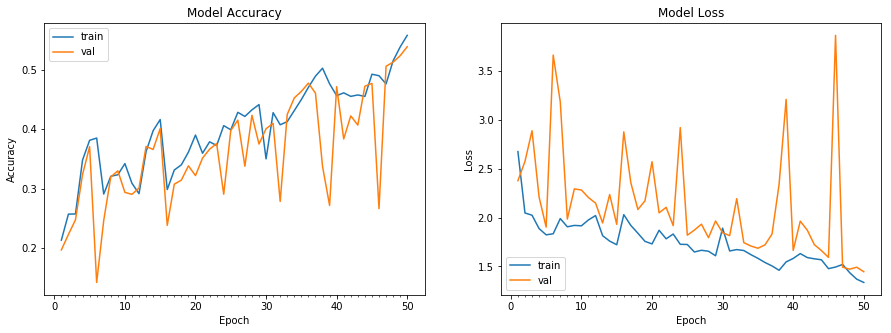

Accuracy on test data is: 53.92


In [71]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))